# Gradientes y diferenciación automática

* 30:00 min | Última modificación: Mayo 10, 2021 | [YouTube]

Adaptado de:

* https://www.tensorflow.org/tutorials/keras/keras_tuner

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

tf.__version__

'2.4.1'

## Cálculo del gradiente respecto a una variable

In [2]:
#
# Define la variable
#
x = tf.Variable(3.0)

#
# GradienteTape permite recordar la
#  evaluación para realizar posteriormente
#  el cálculo del gradiente
#
with tf.GradientTape() as tape:
    y = x ** 2

#
# Gradiente de y respecto a x
#
#    dy = 2x * dx
#
tape.gradient(y, x).numpy()

6.0

## Cálculo de gradientes de alto orden

In [3]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

with tf.GradientTape() as outer_tape:
    outer_tape.watch(a)
    with tf.GradientTape() as tape:
        tape.watch(a)
        c = tf.sqrt(tf.square(a) + tf.square(b))
        dc_da = tape.gradient(c, a)
    d2c_da2 = outer_tape.gradient(dc_da, a)

d2c_da2

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.24225843, 0.32936358],
       [0.17959702, 0.20424438]], dtype=float32)>

## Cálculo del gradiente respecto a un tensor

In [4]:
#
# Define un modelo de regresión lineal
# y = x @ w + b
#
w = tf.Variable(
    tf.random.normal(
        (3, 2),
    ),
    name="w",
)

b = tf.Variable(
    tf.zeros(2, dtype=tf.float32),
    name="b",
)

x = [
    [1.0, 2.0, 3.0],
]

with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y ** 2)

[dloss_dw, dloss_db] = tape.gradient(loss, [w, b])

dloss_dw.numpy(), dloss_db.numpy()

(array([[ -5.714036,  -7.483807],
        [-11.428072, -14.967614],
        [-17.142109, -22.451422]], dtype=float32),
 array([-5.714036, -7.483807], dtype=float32))

Here is the gradient calculation again, this time passing a dictionary of variables:

In [5]:
#
# El mismo cálculo anterior se puede realizar
# sustituyendo la lista de variables por un
# diccionario. Note que retorna un diccionario
#

tape.gradient(loss, {"w": w, "b": b})

{'w': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ -5.714036,  -7.483807],
        [-11.428072, -14.967614],
        [-17.142109, -22.451422]], dtype=float32)>,
 'b': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-5.714036, -7.483807], dtype=float32)>}

## Gradientes respecto a un modelo

In [6]:
#
# Define una capa de 2 neuronas
#
layer = tf.keras.layers.Dense(
    2,
    activation="relu",
)

#
# Vector de entrada
#
x = tf.constant(
    [
        [1.0, 2.0, 3.0],
    ]
)

#
# Define el cálculo a ejecutar con x
#
with tf.GradientTape() as tape:
    #
    # Propagación hacia adelante de x
    #
    y = layer(x)
    loss = tf.reduce_mean(y ** 2)

#
# Cómputo del gradiente
#
grad = tape.gradient(
    loss,
    layer.trainable_variables,
)

#
# Imprime los tamaños de las variables que contenen
#  los gradientes
#
for var, g in zip(layer.trainable_variables, grad):
    print("{}, shape: {}".format(var.name, g.shape))

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


## Control del GradientTape

In [7]:
#
# Variable entrenable
#
x0 = tf.Variable(
    3.0,
    name="x0",
)

#
# Variable no entrenable
#
x1 = tf.Variable(
    3.0,
    name="x1",
    trainable=False,
)

#
# x2 es un tensor, no una variable
#
x2 = tf.Variable(2.0, name="x2") + 1.0

#
# Un tensor
#
x3 = tf.constant(3.0, name="x3")

#
# Evalua y = x0^2 + x1^2 + x2^2
#  Note que no usa x3
#
with tf.GradientTape() as tape:
    y = (x0 ** 2) + (x1 ** 2) + (x2 ** 2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
    print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


In [8]:
#
# Variables monitoreadas por GradientTape
#
[var.name for var in tape.watched_variables()]

['x0:0']

In [9]:
#
# Este es un tensor que por defecto no es
# monitoreado por GradientTape
#
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    #
    # watch() permite adicionar elementos
    # a ser monitoreados por GradientTape
    #
    tape.watch(x)
    y = x ** 2


#
# Computdo de la derivada
# dy = 2x * dx
#
tape.gradient(y, x).numpy()

6.0

Conversely, to disable the default behavior of watching all `tf.Variables`, set `watch_accessed_variables=False` when creating the gradient tape. This calculation uses two variables, but only connects the gradient for one of the variables:

In [10]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

#
# La opción watch_accessed_variables desactiva el
# comportamiento por defecto y ninguna variable será
# monitoreada por GradientTape
#
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1)
    y0 = tf.math.sin(x0)
    y1 = tf.nn.softplus(x1)
    y = y0 + y1
    ys = tf.reduce_sum(y)

#
# Computo del gradiente. Note que no se calcula
# el gradiente respecto a x0
#
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
#
tape.gradient(ys, {"x0": x0, "x1": x1})

{'x0': None, 'x1': <tf.Tensor: shape=(), dtype=float32, numpy=0.9999546>}

## Gradiente respecto a resultados intermedios

In [11]:
#
# Crea una constante
#
x = tf.constant(3.0)

with tf.GradientTape() as tape:
    #
    # Monitorea x
    #
    tape.watch(x)
    y = x * x
    z = y * y

#
# Cómputo del gradiente de z respecto a y
# dz_dy = 2 * y, y = x ** 2 = 9
#
print(tape.gradient(z, y).numpy())

18.0


By default, the resources held by a `GradientTape` are released as soon as the `GradientTape.gradient` method is called. To compute multiple gradients over the same computation, create a gradient tape with `persistent=True`. This allows multiple calls to the `gradient` method as resources are released when the tape object is garbage collected. For example:

In [12]:
x = tf.constant([1, 3.0])

#
# La opción persistent permite computar
# varios gradientes en la misma operación
#
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = x * x
    z = y * y

#
# Gradiente de z respecto a x
# 108.0 (4 * x**3 at x = 3)
#
tape.gradient(z, x).numpy()

array([  4., 108.], dtype=float32)

In [13]:
#
# Gradiente de y respecto a x
# 6.0 (2 * x)
#
tape.gradient(y, x).numpy()

array([2., 6.], dtype=float32)

In [14]:
#
# Borra la variable
#
del tape

## Cómputo de gradientes de no escalares

In [15]:
#
# Gradiente de un escalar
#
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
    y0 = x ** 2
    y1 = 1 / x

tape.gradient(y0, x).numpy(), tape.gradient(y1, x).numpy()

(4.0, -0.25)

Thus, if you ask for the gradient of multiple targets, the result for each source is:

* The gradient of the sum of the targets, or equivalently
* The sum of the gradients of each target.

In [16]:
#
# Mismo gradiente anterior, pero con persistent=False
x = tf.Variable(2.0)

with tf.GradientTape() as tape:
    y0 = x ** 2
    y1 = 1 / x

#
# Acá no se puede usar la opción anterior porque
# el gradiente no es persistente. Se cómputa
# como la suma de los dos gradientes anteriores
#
tape.gradient({"y0": y0, "y1": y1}, x).numpy()

3.75

Similarly, if the target(s) are not scalar the gradient of the sum is calculated:

In [17]:
#
# Similar al anterior pero x es multiplicado
#  por una lista
#
x = tf.Variable(2.0)

with tf.GradientTape() as tape:
    y = x * [3.0, 4.0]

tape.gradient(y, x).numpy()

7.0

## Gráfico de la derivada de la función sigmoidea

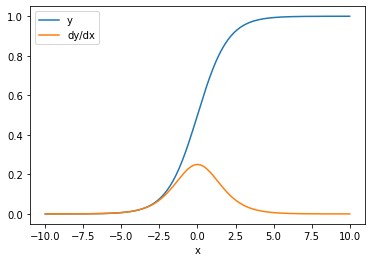

In [18]:
#
# Valores del eje X
#
x = tf.linspace(-10.0, 10.0, 200 + 1)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

plt.plot(x, y, label="y")
plt.plot(x, dy_dx, label="dy/dx")
plt.legend()
plt.xlabel("x")
plt.show()

## Control de flujo

In [19]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:

    tape.watch(x)

    if x > 0.0:
        result = v0
    else:
        result = v1 ** 2

dv0, dv1 = tape.gradient(result, [v0, v1])
dv0, dv1

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, None)

In [20]:
tape.gradient(result, x)

## Causas de resultados igual a None

In [21]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as tape:
    #
    # No hay causalidad de x con z
    #
    z = y * y

print(tape.gradient(z, x))

None


In [22]:
x = tf.Variable(2.0)

for epoch in range(2):

    with tf.GradientTape() as tape:
        #
        # Se reemplaza inadvertidamente una
        # variable con un tensor
        #
        y = x + 1

    print(type(x).__name__, ":", tape.gradient(y, x))
    x = x + 1

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


In [23]:
x = tf.Variable(
    [
        [1.0, 2.0],
        [3.0, 4.0],
    ],
    dtype=tf.float32,
)

with tf.GradientTape() as tape:
    x2 = x ** 2
    #
    # Cálculo fuera de TensorFlow
    #
    y = np.mean(x2, axis=0)
    y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


### 3. Took gradients through an integer or string

Integers and strings are not differentiable. If a calculation path uses these data types there will be no gradient.

Nobody expects strings to be differentiable, but it's easy to accidentally create an `int` constant or variable if you don't specify the `dtype`.

In [24]:
x = tf.constant(10)

with tf.GradientTape() as tape:
    #
    # Cálculo del gradiente respecto a
    # un entero o un string
    #
    tape.watch(x)
    y = x * x

print(tape.gradient(y, x))

None


In [25]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
    #
    # La siguiente función no recuerda
    # x0 en el GradientTape
    #
    x1.assign_add(x0)
    y = x1 ** 2

print(tape.gradient(y, x0))

None


In [26]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
    x1 = x1 + x0
    y = x1 ** 2

print(tape.gradient(y, x0))

tf.Tensor(6.0, shape=(), dtype=float32)


## Reemplazo de None por Zero

In [27]:
x = tf.Variable([2.0, 2.0])
y = tf.Variable(3.0)

with tf.GradientTape() as tape:
    z = y ** 2

#
# Se usa en casos en los que es más conveniente
#  obtener 0 en vez de None
#
tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>